This code is licensed to University of Quesland. You are not permitted to share or distribute this code**

In [1]:
%%time
### GPU configuration
! nvidia-smi

Thu Feb 22 15:59:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%%time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 1.2 s, sys: 208 ms, total: 1.41 s
Wall time: 29.1 s


In [3]:
%%time
!pip install tensorflow_addons
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.6 MB/s eta 0:00:00
CPU times: user 84.3 ms, sys: 6.89 ms, total: 91.2 ms
Wall time: 10.6 s


In [5]:
%%time
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from matplotlib import pyplot as plt
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import numpy as np
import pandas as pd
import os
import time
import cv2
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

CPU times: user 49.7 ms, sys: 30.3 ms, total: 80 ms
Wall time: 609 ms


In [9]:
%%time
labels = ["Cucumber Mosaic Virus", "Downy Mildew", "Leaf Spot"]
img_size = 32
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        # Loop through images in the current label's directory
        for img in os.listdir(path):
            try:
                # Read and convert the image to RGB format
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]

                # Resize the image to the preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size))

                # Append the resized image and its class number to the data list
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error reading or processing image {img} in {label} category: {e}")

    return data

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


In [10]:
%%time
data_dir = get_data("/content/drive/MyDrive/Luffa Aegyptiaca 480")

CPU times: user 25.3 s, sys: 1.83 s, total: 27.1 s
Wall time: 3min 39s


In [12]:
%%time
image_names = glob.glob(os.path.join('/content/drive/MyDrive/Luffa Aegyptiaca 480', '*', '*'))
print("Total number of training images: ", len(image_names))

# Make image_names a pandas Series object
image_names = pd.Series(image_names)


Total number of training images:  6533
CPU times: user 24.7 ms, sys: 790 µs, total: 25.5 ms
Wall time: 156 ms


In [13]:
%%time
# train_df: a dataframe with 2 field: Filename, ClassId
data_df = pd.DataFrame()

# generate Filename field
data_df['Filename'] = image_names.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
data_df['ClassId'] = image_names.map(lambda img_name: (img_name.split("/")[-2]))

data_df.head()

CPU times: user 11.7 ms, sys: 969 µs, total: 12.6 ms
Wall time: 21.8 ms


,Filename,ClassId
0,Downey-Mildew (1754).jpg,Downy Mildew
1,Downey-Mildew (259).jpg,Downy Mildew
2,Downey-Mildew (1753).jpg,Downy Mildew
3,Downey-Mildew (762).jpg,Downy Mildew
4,Downey-Mildew (256).jpg,Downy Mildew


CPU times: user 169 ms, sys: 14 ms, total: 183 ms
Wall time: 245 ms


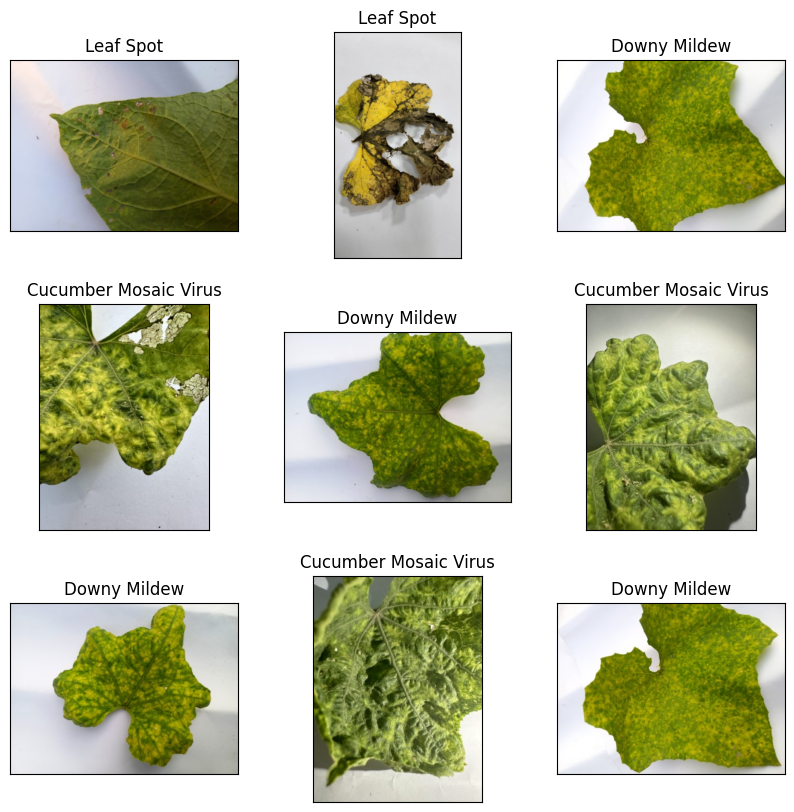

In [14]:
%%time
plot_df = data_df.sample(min(9, len(data_df))).reset_index()

plt.figure(figsize=(10, 10))

for i in range(9):
    img_name = plot_df.loc[i, 'Filename']
    label_str = (plot_df.loc[i, 'ClassId'])
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(os.path.join('/content/drive/MyDrive/Luffa Aegyptiaca 480',label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])

In [15]:
%%time
class_id_distribution = data_df['ClassId'].value_counts()
class_id_distribution.head(10)

CPU times: user 3.57 ms, sys: 0 ns, total: 3.57 ms
Wall time: 3.87 ms


Leaf Spot                2505
Downy Mildew             2024
Cucumber Mosaic Virus    2004
Name: ClassId, dtype: int64

CPU times: user 88.8 ms, sys: 2.9 ms, total: 91.7 ms
Wall time: 98.2 ms


<BarContainer object of 3 artists>

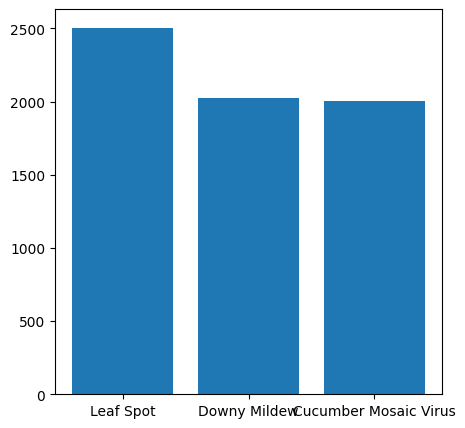

In [16]:
%%time
plt.figure(figsize=(5,5))
plt.xticks(np.arange(43))
plt.bar(class_id_distribution.index, class_id_distribution.values)

CPU times: user 16.2 ms, sys: 0 ns, total: 16.2 ms
Wall time: 18 ms


Text(0.5, 1.0, 'Cucumber Mosaic Virus')

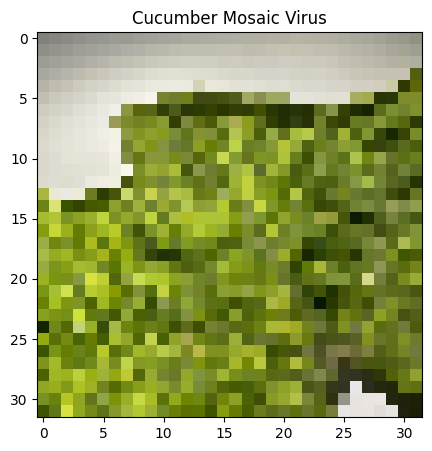

In [17]:
%%time
plt.figure(figsize = (5,5))
plt.imshow(data_dir[1][0])
plt.title(labels[data_dir[0][1]])


In [18]:
%%time
X = []
Y = []


for feature, label in data_dir:
  X.append(feature)
  Y.append(label)
X = np.array(X) / 255
X.reshape(-1, img_size, img_size, 1)
Y = np.array(Y)

CPU times: user 30.2 ms, sys: 35.1 ms, total: 65.4 ms
Wall time: 65.8 ms


In [19]:
%%time
print(X.shape)

(6533, 32, 32, 3)
CPU times: user 765 µs, sys: 0 ns, total: 765 µs
Wall time: 959 µs


In [20]:
%%time
# split with a stratified sampling
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.10, stratify=Y, random_state=42)

CPU times: user 19.9 ms, sys: 31.3 ms, total: 51.1 ms
Wall time: 51.2 ms


In [21]:
%%time
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
    test_size=0.18, random_state= 8) # 0.25 x 0.8 = 0.2

CPU times: user 16 ms, sys: 35.3 ms, total: 51.3 ms
Wall time: 53.5 ms


In [22]:
%%time
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (4820, 32, 32, 3) - y_train shape: (4820,)
x_val shape: (1059, 32, 32, 3) - y_val shape: (1059,)
x_test shape: (654, 32, 32, 3) - y_test shape: (654,)
CPU times: user 2.01 ms, sys: 0 ns, total: 2.01 ms
Wall time: 3.95 ms


In [23]:
%%time
!pip install -U tensorflow-addons

CPU times: user 48 ms, sys: 9.44 ms, total: 57.5 ms
Wall time: 6.23 s


In [24]:
%%time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

CPU times: user 18 µs, sys: 2 µs, total: 20 µs
Wall time: 23.6 µs


In [25]:
%%time
num_classes = 3
input_shape = (32, 32, 3)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [26]:
%%time
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 250
image_size = 32  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 3
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 1
mlp_head_units = [2048, 1024]

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 10 µs


In [27]:
%%time
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

CPU times: user 1.76 s, sys: 524 ms, total: 2.29 s
Wall time: 4.36 s


In [28]:
%%time
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


In [29]:
%%time
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

CPU times: user 49 µs, sys: 5 µs, total: 54 µs
Wall time: 58.2 µs


Image size: 32 X 32
Patch size: 8 X 8
Patches per image: 16
Elements per patch: 192
CPU times: user 289 ms, sys: 21.4 ms, total: 311 ms
Wall time: 320 ms


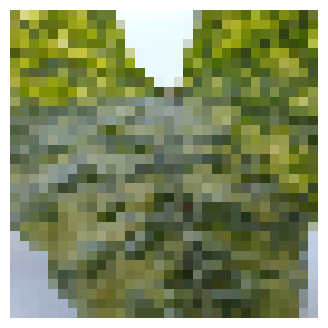

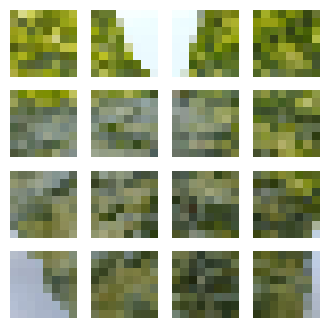

In [30]:
%%time
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("float"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("float"))
    plt.axis("off")

In [31]:
%%time
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

CPU times: user 0 ns, sys: 105 µs, total: 105 µs
Wall time: 56 µs


In [32]:
%%time
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 7.39 µs


In [33]:
%%time
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    model.summary()

    checkpoint_filepath = "/content/drive/MyDrive/model/model64_12.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,

        lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                  cooldown= 10,
                                                  patience=10,
                                                  verbose =1,
                                                  min_lr=0.1e-7),


# stop learining as metric on validatopn stop increasing
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=15,
                                                  verbose=1,
                                                  mode = 'auto')
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 7.39 µs


In [34]:
%%time
vit_classifier = create_vit_classifier()
vit_history = run_experiment(vit_classifier)

Cause: Unable to locate the source code of <bound method Patches.call of <__main__.Patches object at 0x7ab5e53e2ec0>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <bound method Patches.call of <__main__.Patches object at 0x7ab5e53e2ec0>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <bound method PatchEncoder.call of <__main__.PatchEncoder object at 0x7ab638866d10>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <bound method PatchEncoder.call of <__main__.PatchEncoder object at 0x7ab638866d10>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augmentation (Seque

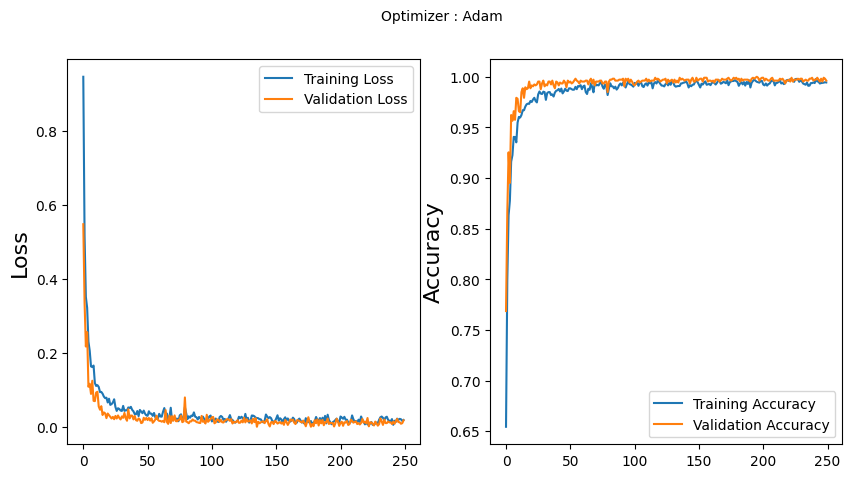

CPU times: user 316 ms, sys: 102 ms, total: 418 ms
Wall time: 306 ms


In [35]:
%%time
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(vit_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [36]:
%%time
vit_predictions = vit_classifier.predict(x_val)
vit_y_pred = [np.argmax(probas) for probas in vit_predictions]

34/34 [==============================] - 0s 4ms/step
CPU times: user 500 ms, sys: 26.4 ms, total: 526 ms
Wall time: 494 ms


In [37]:
%%time
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 12.4 µs


Confusion matrix, without normalization
[[305   0   0]
 [  0 333   0]
 [  0   0 421]]


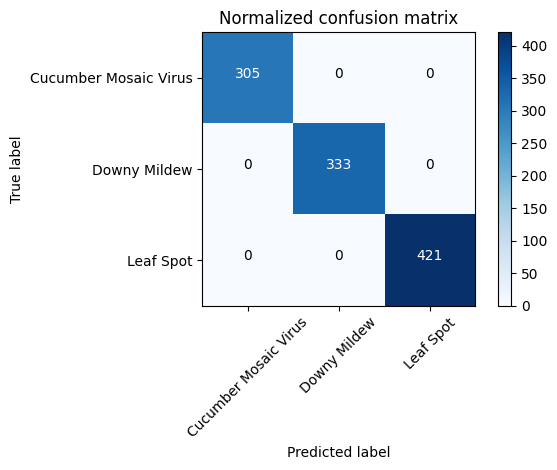

CPU times: user 258 ms, sys: 129 ms, total: 387 ms
Wall time: 252 ms


In [38]:
%%time
# compute confusion matrix
cnf_matrix = confusion_matrix(y_val, vit_y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Cucumber Mosaic Virus", "Downy Mildew", "Leaf Spot"], title='Normalized confusion matrix')
plt.show()

In [39]:
%%time
print(classification_report(y_val, vit_y_pred, target_names=["Cucumber Mosaic Virus", "Downy Mildew", "Leaf Spot"]))



                       precision    recall  f1-score   support

Cucumber Mosaic Virus       1.00      1.00      1.00       305
         Downy Mildew       1.00      1.00      1.00       333
            Leaf Spot       1.00      1.00      1.00       421

             accuracy                           1.00      1059
            macro avg       1.00      1.00      1.00      1059
         weighted avg       1.00      1.00      1.00      1059

CPU times: user 6.42 ms, sys: 0 ns, total: 6.42 ms
Wall time: 6.43 ms


In [40]:
%%time
vit_predictions = vit_classifier.predict(x_test)
vit_y_pred = [np.argmax(probas) for probas in vit_predictions]

21/21 [==============================] - 0s 5ms/step
CPU times: user 199 ms, sys: 5.04 ms, total: 204 ms
Wall time: 204 ms


In [41]:
%%time
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11 µs


Confusion matrix, without normalization
[[200   0   0]
 [  0 203   0]
 [  0   0 251]]


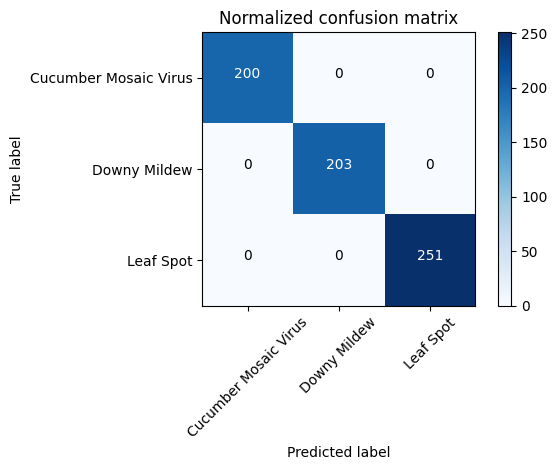

CPU times: user 280 ms, sys: 75.9 ms, total: 356 ms
Wall time: 328 ms


In [42]:
%%time
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, vit_y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["Cucumber Mosaic Virus", "Downy Mildew", "Leaf Spot"], title='Normalized confusion matrix')
plt.show()

In [45]:
%%time
print(classification_report(y_test, vit_y_pred, target_names=["Cucumber Mosaic Virus", "Downy Mildew", "Leaf Spot"]))



                       precision    recall  f1-score   support

Cucumber Mosaic Virus       1.00      1.00      1.00       200
         Downy Mildew       1.00      1.00      1.00       203
            Leaf Spot       1.00      1.00      1.00       251

             accuracy                           1.00       654
            macro avg       1.00      1.00      1.00       654
         weighted avg       1.00      1.00      1.00       654

CPU times: user 9.24 ms, sys: 745 µs, total: 9.99 ms
Wall time: 10.9 ms
